## ATAC + MULTIOME (females)

### Build anndata from cellatac output 

In [1]:
# Load libraries
import pandas as pd 
import scanpy as sc
import numpy as np
import scipy.sparse

/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/females_apr2021/"
experiment_prefix = 'females_'
cellatac_outdir = '/lustre/scratch117/cellgen/cellgeni/TIC-atacseq/tic-1004/female/results200k-b-female/'


In [3]:
input={'cnts': cellatac_outdir + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir + experiment_prefix + '_ATAC_raw.h5ad',
}

#### Make anndata object

In [4]:
adata = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header=None)
feat = pd.read_table(input["peaks"], header=None)

adata.obs_names = bc[0]
adata.var_names = feat[0]

In [5]:
adata

AnnData object with n_obs × n_vars = 74619 × 489023

In [6]:
# Code from cell barcodes 
adata.obs['code'] = [name[0:2] for name in adata.obs_names]
adata.obs['code'].value_counts(dropna = False)

07    12913
05    10160
06     8901
01     8668
08     8394
11     5326
12     4974
04     4878
10     3661
03     3458
09     2114
02     1172
Name: code, dtype: int64

In [7]:
# Sample from code 
sample_dictionary = {'01' : 'FCA_GND8046539', '02' : 'FCA_GND8768483', '03' : 'FCA_GND8768484', 
                    '04' : 'FCA_GND8768485', '05' : 'HD_F_GON9479871', '06' : 'HD_F_GON9479873', 
                     '07' : 'HD_F_GON9479874', '08' : 'HD_F_GON9479875', '09' : 'HD_F_GON9525613', 
                     '10' : 'HD_F_GON9525614', '11' : 'HD_F_GON9883959', '12' : 'HD_F_GON9883960'}
adata.obs['sample'] = adata.obs['code'].map(sample_dictionary) 
adata.obs['sample'].value_counts(dropna = False)

HD_F_GON9479874    12913
HD_F_GON9479871    10160
HD_F_GON9479873     8901
FCA_GND8046539      8668
HD_F_GON9479875     8394
HD_F_GON9883959     5326
HD_F_GON9883960     4974
FCA_GND8768485      4878
HD_F_GON9525614     3661
FCA_GND8768484      3458
HD_F_GON9525613     2114
FCA_GND8768483      1172
Name: sample, dtype: int64

#### Load peak annotations (done with R script by Emma)

In [8]:
peak_anno_df = pd.read_csv(outdir + "ATACpeaks_annotation.csv", index_col=0)
peak_anno_df.index = peak_anno_df["peak_id"]
peak_anno_df.drop("peak_id",1, inplace=True)
adata.var = pd.concat([adata.var, peak_anno_df], 1)

#### Save binary data to layers

In [9]:
adata.layers["binary_raw"] = adata.X
adata.layers["binary_raw"][adata.layers["binary_raw"] > 1] = 1
adata

AnnData object with n_obs × n_vars = 74619 × 489023
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist'
    layers: 'binary_raw'

**Peak filtering**

array([[<AxesSubplot:title={'center':'peak_width'}>]], dtype=object)

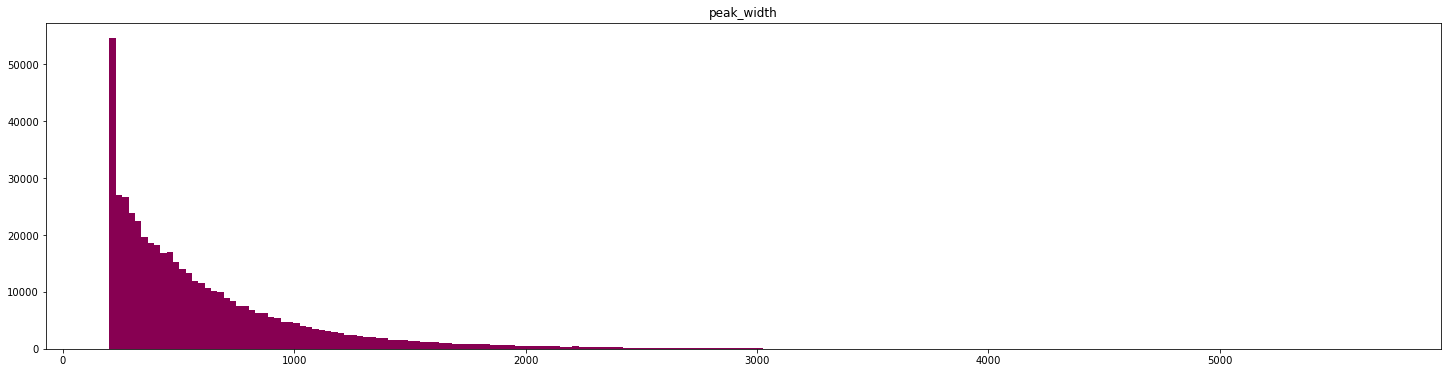

In [10]:
adata.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [11]:
var_qc = sc.pp.calculate_qc_metrics(adata, layer = "binary_raw")[1]
adata.var = pd.concat([adata.var, var_qc], 1)
adata

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


AnnData object with n_obs × n_vars = 74619 × 489023
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [12]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:9997-10487,491,0,0,0,intergenic,NaN,NaN,58603,1,721,0.009662,0.009616,99.033758,721.0,6.582025
chr1:16110-16320,211,0,0,0,intergenic,NaN,NaN,52770,1,176,0.002359,0.002356,99.764135,176.0,5.176150
chr1:180675-181619,945,0,0,1,promoter,FO538757.2,ENSG00000279928,773,1,2924,0.039186,0.038437,96.081427,2924.0,7.981050
chr1:191305-191940,636,0,1,0,intron,FO538757.1,ENSG00000279457,3470,1,404,0.005414,0.005400,99.458583,404.0,6.003887
chr1:267865-268100,236,0,0,0,intergenic,NaN,NaN,67542,1,806,0.010802,0.010744,98.919846,806.0,6.693324


array([[<AxesSubplot:title={'center':'total_counts'}>]], dtype=object)

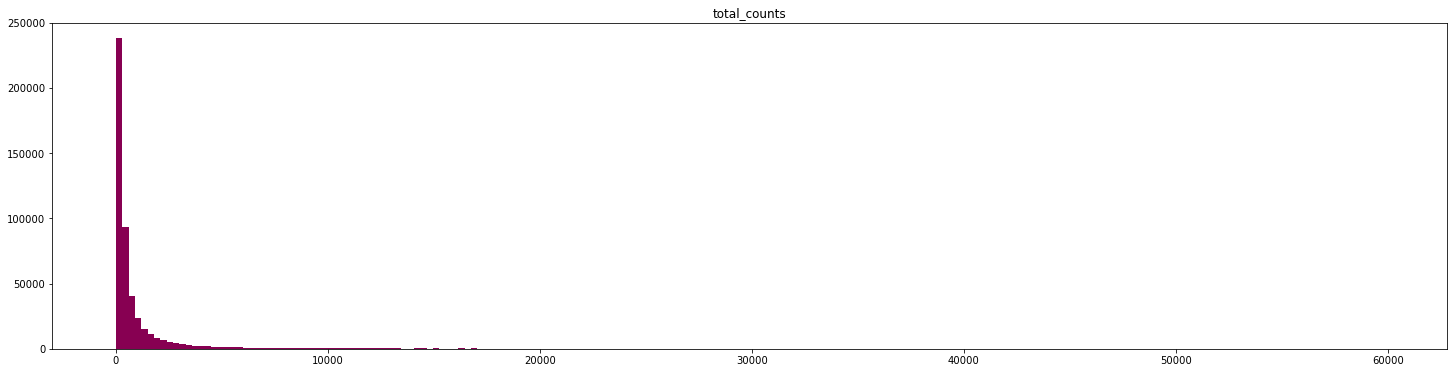

In [13]:
adata.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [14]:
thirty_percent = len(adata.obs_names) / 100 * 30
point_one_percent = len(adata.obs_names) / 100 * 0.1
print("30% : {}".format(thirty_percent))
print("0.1% : {}".format(point_one_percent))

30% : 22385.7
0.1% : 74.61900000000001


In [15]:
# Accessible in at least k cells
adata = adata[:,adata.var.total_counts > point_one_percent]
adata = adata[:,adata.var.total_counts < thirty_percent]
adata

View of AnnData object with n_obs × n_vars = 74619 × 464221
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [16]:
# Remove peaks in ENCODE blacklist
adata = adata[:, adata.var.ENCODE_blacklist == 0]
adata

View of AnnData object with n_obs × n_vars = 74619 × 462500
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [17]:
# Filter by width (remove peaks at the lowest end, closest to min peak width in MACS2)

adata = adata[:, adata.var.peak_width > 210]
adata = adata[:, adata.var.peak_width < 1500]
adata

View of AnnData object with n_obs × n_vars = 74619 × 413897
    obs: 'code', 'sample'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [18]:
adata.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:816836-817441,606,0,0,0,intergenic,NaN,NaN,106486,0,721,0.009662,0.009616,99.033758,721.0,6.582025
chr1:817738-818526,789,0,0,0,intergenic,NaN,NaN,105401,0,737,0.009877,0.009828,99.012316,737.0,6.603944
chr1:821280-821617,338,0,0,0,intergenic,NaN,NaN,102310,0,230,0.003082,0.003078,99.691768,230.0,5.442418
chr1:825667-826063,397,0,0,0,intergenic,NaN,NaN,97864,0,605,0.008108,0.008075,99.189215,605.0,6.406880
chr1:826596-827809,1214,0,0,0,intergenic,NaN,NaN,96118,0,10591,0.141934,0.132724,85.806564,10591.0,9.267855


In [19]:
adata.var['annotation'].value_counts()

intergenic    187717
intron        171232
exon           42254
promoter       12694
Name: annotation, dtype: int64

In [20]:
adata.obs.head()

,code,sample
01-AAACGAAAGGCTCCTG-1,01,FCA_GND8046539
01-AAACGAAAGTCCAGAG-1,01,FCA_GND8046539
01-AAACGAACAATGGTAA-1,01,FCA_GND8046539
01-AAACGAACACCCATCT-1,01,FCA_GND8046539
01-AAACGAACAGGTCTGC-1,01,FCA_GND8046539


In [21]:
### Filter peaks that are not accessible in at least 4% of cells from a coarse cluster
min_frac=0.04
# Load cluster information from cellatac outputs
clusters = pd.read_table(input["clusters"], header = None, index_col = 0)
clusters.columns = ["cellatac_clusters"]
adata.obs = clusters.loc[adata.obs_names]
adata

AnnData object with n_obs × n_vars = 74619 × 413897
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [22]:
adata.obs.head()

,cellatac_clusters
01-AAACGAAAGGCTCCTG-1,4
01-AAACGAAAGTCCAGAG-1,4
01-AAACGAACAATGGTAA-1,13
01-AAACGAACACCCATCT-1,8
01-AAACGAACAGGTCTGC-1,4


In [23]:
n_clusters = len(np.unique(adata.obs[["cellatac_clusters"]]))
clus_mat = np.empty([adata.n_obs, n_clusters])
for cl in np.unique(adata.obs[["cellatac_clusters"]]):
    clus_mat[np.where(adata.obs['cellatac_clusters']==cl)[0],cl] = 1

clus_mat = scipy.sparse.csr_matrix(clus_mat)
clus_mat[clus_mat != 1 ] = 0

/opt/conda/envs/atac_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/envs/atac_env/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [24]:
cl_peak_mat = np.dot(clus_mat.T, adata.layers["binary_raw"])

In [25]:
cl_peak_frac = cl_peak_mat/clus_mat.sum(0).T

In [26]:
cl_peak_frac.max(0).shape

(1, 413897)

In [27]:
bool_matrix = cl_peak_frac.max(0) > min_frac
bool_matrix.shape

(1, 413897)

In [28]:
bool_vector = np.squeeze(np.asarray(bool_matrix))
bool_vector.shape

(413897,)

In [29]:
adata = adata[:, bool_vector]

In [30]:
adata

View of AnnData object with n_obs × n_vars = 74619 × 201343
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [31]:
sc.pp.calculate_qc_metrics(adata, layer = "binary_raw", inplace = True)

Trying to set attribute `.obs` of view, copying.


array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

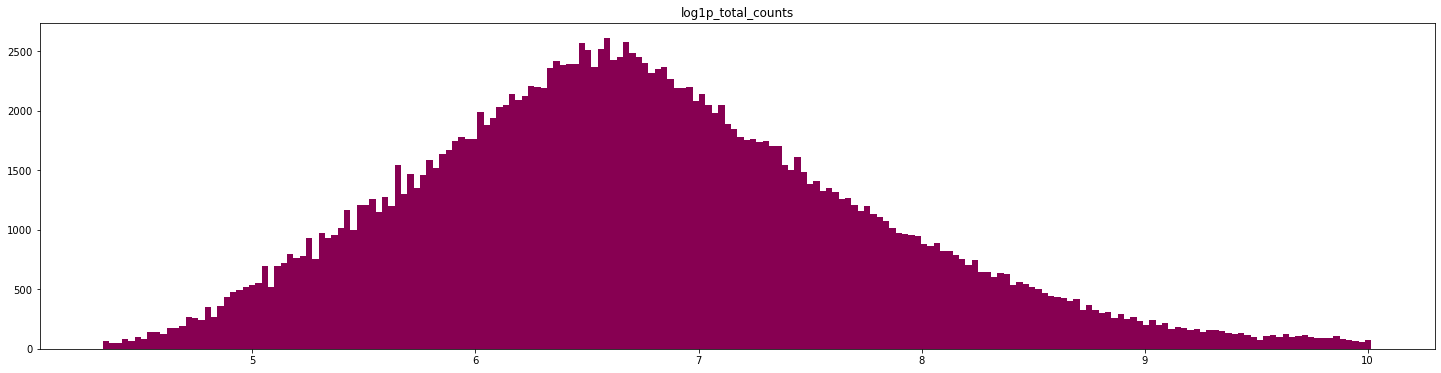

In [32]:
adata.var.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

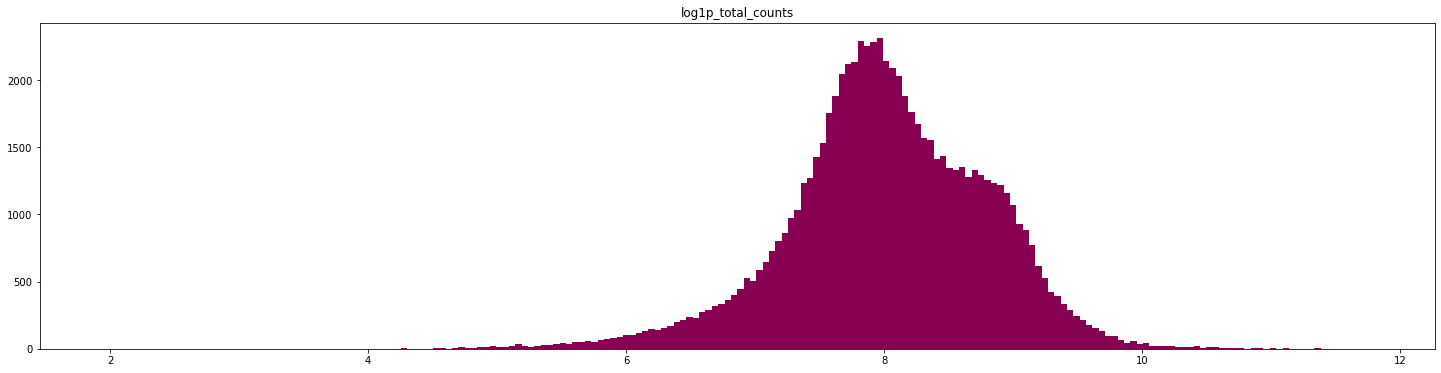

In [33]:
adata.obs.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [34]:
adata = adata[adata.obs.log1p_total_counts >= 5.5]
adata

View of AnnData object with n_obs × n_vars = 74282 × 201343
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [35]:
## Write output anndata
adata.write_h5ad(output["h5ad"])

/opt/conda/envs/atac_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'annotation' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_name' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'gene_id' as categorical


#### End of notebook